### Import packages

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math 
from scipy.optimize import minimize


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Preprocessing 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve, validation_curve

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

## Part A

### Predict propensity to pay renewal premium

### Functions

In [2]:
# Create table for missing data analysis
def missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [3]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Validation score")

    plt.legend(loc="best")
    return plt

In [4]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

### Read and Understand the data

In [5]:
train_df = pd.read_csv('train_ZoGVYWq.csv')
test_df = pd.read_csv('test_66516Ee.csv')
combine = [train_df, test_df] 

In [6]:
train_df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [7]:
train_df.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,28640.000000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,85632.000000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,114076.000000,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
id                                  79853 non-null int64
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
Income                              79853 non-null int64
Count_3-6_months_late               79756 non-null float64
Count_6-12_months_late              79756 non-null float64
Count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
dtypes: float64(5), int64(6), object(2)
memory usage: 7.9+ MB


In [9]:
test_df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [10]:
test_df.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium
count,34224.000000,34224.000000,34224.000000,3.422400e+04,34193.000000,34193.000000,34193.000000,32901.000000,34224.000000,34224.000000
mean,56739.956376,0.314457,18824.215346,2.028201e+05,0.238733,0.080718,0.058111,99.061898,10.890428,10834.721248
std,32935.402647,0.334059,5246.525604,2.702536e+05,0.686162,0.454634,0.307046,0.742942,5.216867,9263.074506
min,1.000000,0.000000,7671.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000
25%,28254.750000,0.034000,14972.000000,1.063975e+05,0.000000,0.000000,0.000000,98.800000,7.000000,5400.000000
50%,56488.000000,0.169000,18623.000000,1.650700e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000
75%,85386.250000,0.540000,22636.000000,2.500200e+05,0.000000,0.000000,0.000000,99.530000,14.000000,13800.000000
max,114077.000000,1.000000,35785.000000,2.191455e+07,12.000000,10.000000,7.000000,99.890000,59.000000,60000.000000


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34224 entries, 0 to 34223
Data columns (total 12 columns):
id                                  34224 non-null int64
perc_premium_paid_by_cash_credit    34224 non-null float64
age_in_days                         34224 non-null int64
Income                              34224 non-null int64
Count_3-6_months_late               34193 non-null float64
Count_6-12_months_late              34193 non-null float64
Count_more_than_12_months_late      34193 non-null float64
application_underwriting_score      32901 non-null float64
no_of_premiums_paid                 34224 non-null int64
sourcing_channel                    34224 non-null object
residence_area_type                 34224 non-null object
premium                             34224 non-null int64
dtypes: float64(5), int64(5), object(2)
memory usage: 3.1+ MB


### EDA

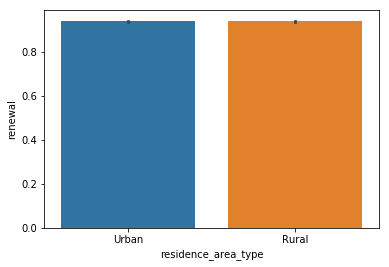

In [12]:
sns.barplot(train_df['residence_area_type'],train_df['renewal']);

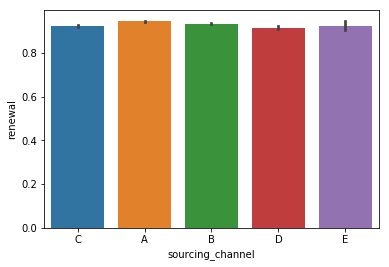

In [13]:
sns.barplot(train_df['sourcing_channel'],train_df['renewal']);

Seems the categorical features doesn't affect the policy renewal.

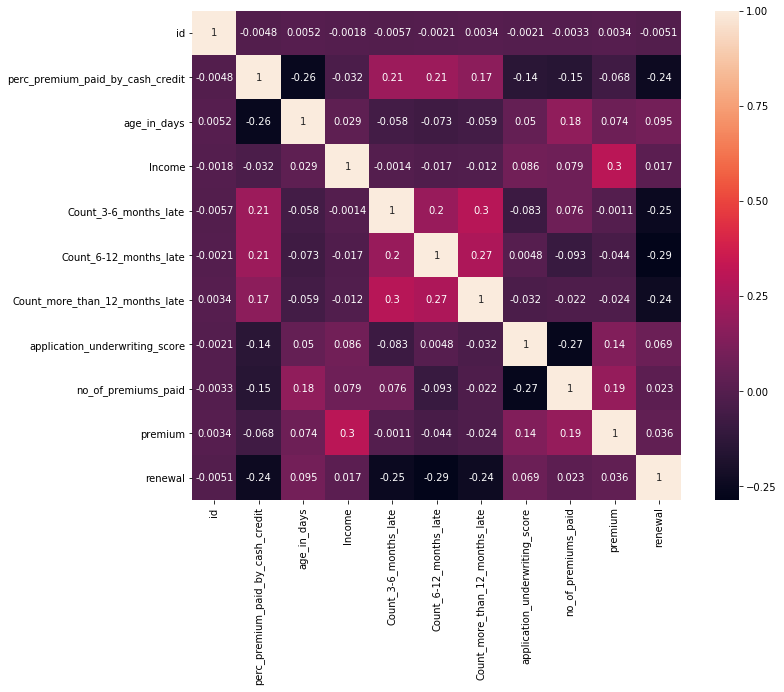

In [14]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=True, annot=True);

Observations :

Columns *perc_premium_paid_by_cash_credit*, *Count_3-6_months_late*, *Count_6-12_months_late* and *Count_more_than_12_months_late* are negatively correlated with *renewal*

Whereas *age_in_days*, *Income*, *application_underwriting_score*, *no_of_premiums_paid* and *premium* are slight positively correlated with *renewal*. 

### Look for missing values and fill the gaps

In [15]:
missing_data_table(train_df)

,Total,Percent
application_underwriting_score,2974,0.037243
Count_more_than_12_months_late,97,0.001215
Count_6-12_months_late,97,0.001215
Count_3-6_months_late,97,0.001215
renewal,0,0.000000
premium,0,0.000000
residence_area_type,0,0.000000
sourcing_channel,0,0.000000
no_of_premiums_paid,0,0.000000
Income,0,0.000000


In [16]:
missing_data_table(test_df)

,Total,Percent
application_underwriting_score,1323,0.038657
Count_more_than_12_months_late,31,0.000906
Count_6-12_months_late,31,0.000906
Count_3-6_months_late,31,0.000906
premium,0,0.000000
residence_area_type,0,0.000000
sourcing_channel,0,0.000000
no_of_premiums_paid,0,0.000000
Income,0,0.000000
age_in_days,0,0.000000


We can see that *application_underwriting_score* column have lots of missing values. We'll fill it with mean value

All Count\* column have less missing values and also missing values for all three Count\* columns are in same rows. We'll fill these with zeros.

In [17]:
#lets fill the missing values
for dataset in combine:
    dataset['application_underwriting_score'].fillna(dataset['application_underwriting_score'].mean(),inplace=True)

In [18]:
for dataset in combine:
    dataset['Count_more_than_12_months_late'].fillna(0,inplace=True)
    dataset['Count_6-12_months_late'].fillna(0,inplace=True)
    dataset['Count_3-6_months_late'].fillna(0,inplace=True)

In [19]:
missing_data_table(train_df)

,Total,Percent
renewal,0,0.0
premium,0,0.0
residence_area_type,0,0.0
sourcing_channel,0,0.0
no_of_premiums_paid,0,0.0
application_underwriting_score,0,0.0
Count_more_than_12_months_late,0,0.0
Count_6-12_months_late,0,0.0
Count_3-6_months_late,0,0.0
Income,0,0.0


In [20]:
missing_data_table(test_df)

,Total,Percent
premium,0,0.0
residence_area_type,0,0.0
sourcing_channel,0,0.0
no_of_premiums_paid,0,0.0
application_underwriting_score,0,0.0
Count_more_than_12_months_late,0,0.0
Count_6-12_months_late,0,0.0
Count_3-6_months_late,0,0.0
Income,0,0.0
age_in_days,0,0.0


### Prepare Data

We don't need 'id' for prediction purpose so we'll exclude it.

We'll combine all Count* colums since they affect renewal in same manner.

Also We'll define categorical variables and transform them into dummy variables.

Split data in X_train, y_train, X_test and y_test for training and verification.

We'll also scale the data.

In [21]:
train_df.drop('id', axis=1, inplace=True)
train_df.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [22]:
test_id = test_df['id'].values
test_df.drop('id', axis=1, inplace=True)
test_df.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,0.001,27384,51150,0.0,0.0,0.0,99.890000,7,A,Rural,3300
1,0.124,23735,285140,0.0,0.0,0.0,98.930000,19,A,Urban,11700
2,1.000,17170,186030,0.0,0.0,0.0,99.061898,2,B,Urban,11700
3,0.198,16068,123540,0.0,0.0,0.0,99.000000,11,B,Rural,5400
4,0.041,10591,200020,1.0,0.0,0.0,99.170000,14,A,Rural,9600


In [23]:
#Combine Count* columns 
train_df['Count_late'] = train_df['Count_3-6_months_late'] + train_df['Count_6-12_months_late'] + train_df['Count_more_than_12_months_late']

In [24]:
train_df.drop('Count_3-6_months_late', axis=1, inplace=True)
train_df.drop('Count_6-12_months_late', axis=1, inplace=True)
train_df.drop('Count_more_than_12_months_late', axis=1, inplace=True)
train_df.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal,Count_late
0,0.429,12058,355060,99.02,13,C,Urban,3300,1,0.0
1,0.010,21546,315150,99.89,21,A,Urban,18000,1,0.0
2,0.917,17531,84140,98.69,7,C,Rural,3300,0,6.0
3,0.049,15341,250510,99.57,9,A,Urban,9600,1,0.0
4,0.052,31400,198680,99.87,12,B,Urban,9600,1,0.0


In [25]:
test_df['Count_late'] = test_df['Count_3-6_months_late'] + test_df['Count_6-12_months_late'] + test_df['Count_more_than_12_months_late']

In [26]:
test_df.drop('Count_3-6_months_late', axis=1, inplace=True)
test_df.drop('Count_6-12_months_late', axis=1, inplace=True)
test_df.drop('Count_more_than_12_months_late', axis=1, inplace=True)
test_df.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,Count_late
0,0.001,27384,51150,99.890000,7,A,Rural,3300,0.0
1,0.124,23735,285140,98.930000,19,A,Urban,11700,0.0
2,1.000,17170,186030,99.061898,2,B,Urban,11700,0.0
3,0.198,16068,123540,99.000000,11,B,Rural,5400,0.0
4,0.041,10591,200020,99.170000,14,A,Rural,9600,1.0


In [27]:
# Dropping categorical variables since they don't have any affect on renewal

train_df.drop('sourcing_channel', axis=1, inplace=True)
train_df.drop('residence_area_type', axis=1, inplace=True)

In [28]:
test_df.drop('sourcing_channel', axis=1, inplace=True)
test_df.drop('residence_area_type', axis=1, inplace=True)

In [29]:
# Splitting the training dataset
X_train = train_df[train_df.loc[:, train_df.columns != 'renewal'].columns]
y_train = train_df['renewal']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=1)



In [30]:
#Feature Scaling
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Modelling

In [32]:
kfold = StratifiedKFold(n_splits=10)

In [33]:
# Lets test various classifiers

random_state = 1
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","RandomForest","XGBoosting","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [34]:
#DecisionTreeClassifier seems better since other classifiers are overfitting

In [35]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
#y_pred = classifier.predict(X_test)

scores = cross_val_score(classifier, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.895 +/- 0.003


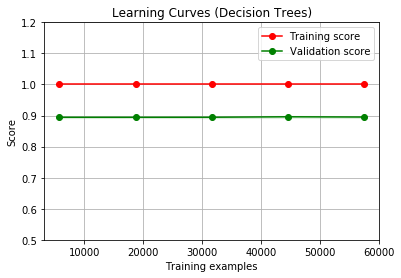

In [37]:
# Plot learning curves
title = "Learning Curves (Decision Trees)"
cv = 10
plot_learning_curve(classifier, title, X_train, y_train, ylim=(0.5, 1.2), cv=cv, n_jobs=1);

### Prediction

In [38]:
#Prediction
X_test_final = test_df[test_df.loc[:,:].columns]
X_test_final= scaler.fit_transform(X_test_final)
ypred = classifier.predict(X_test_final)

## Part B

### Trying to do some calculation to simplify the objective function

In [39]:
# Effort can be at max 10 hrs whatever high value we take for incentive
#(Y is Effort and X is Incentives in below equation)
#Y = 10*(1-exp(-X/400))

effort = 10*(1-math.exp(-100000/400))
effort

10.0

In [40]:
# Percent improvement can be at max 17.3 percent given effort can be at 10 hrs max 
#(Y is Percent Improvement and X is Effort in below equation)
#Y = 20*(1-exp(-X/5))

perc_imp = 20*(1-math.exp(-10/5))
perc_imp

17.293294335267746

In [41]:
#deltap = perc_imp * probablity_of_premium_renewal
# perc_imp = 17.3% = 0.173
#deltap = 0.173*probablity_of_premium_renewal

#Based on these given facts the objective function which needs to be maximized will be 
# sum_across ((probablity_of_premium_renewal + 0.173*probablity_of_premium_renewal)*premium_on_policy - incentive)
# sum_across(1.173*probablity_of_premium_renewal*premium_on_policy - incentive)

### Lets create Objective function which can be maximized

In [42]:
values = 1.173 * test_df.premium*ypred

In [43]:
# We'll return negative of objective function since we are using minimize function from scipy.optimize

def objective(x):
    obj = np.subtract(values, x).sum()
    return -1*obj

In [44]:
x0 = np.random.randint(0, 1000, 34224)
bounds = [[0, 2400] for x in x0] #Generally Incentives are not more than 40% of premium (.40*6000)

In [45]:
print(objective(x0))

-389817290.6999999


In [46]:
res = minimize(objective, x0, method='L-BFGS-B', bounds=bounds, options={'disp': True})

In [47]:
res

      fun: -389817290.6999999
 hess_inv: <34224x34224 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 34225
      nit: 0
   status: 0
  success: True
        x: array([394., 254., 502., ..., 812., 498., 459.])

In [48]:
res.x

array([394., 254., 502., ..., 812., 498., 459.])

In [49]:

submission = pd.DataFrame({ 'id': test_id,
                            'renewal': ypred,
                             'incentives': res.x})

In [50]:

submission.to_csv("submission.csv", index=False)